#  Lab 1: Grade Point Average Prediction

In this Lab we are tasked with designing a system to make admission decisions at the University of Pennsylvania (Penn). In order to design this system we need to acquire data and create a model to substantiate our decisions.

## Lab 1C Neural Networks

## 0. Environment setup



In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn.functional import relu
import random
#random generator seed for reproducibility
np.random.seed(1)
torch.manual_seed(1)
random.seed(1)
# configuration
torch.set_default_dtype(torch.float64)
plt.style.use('default')

data = torch.from_numpy( np.genfromtxt ('data.csv', delimiter=",", skip_header=1, dtype = float ) )

# Compute the mean and standard deviation of each variable.
means = torch.mean(data[:,:3], dim = 0)
stds = torch.std(data[:,:3], dim = 0)

# Substract the mean and divide by the std each variable.
data_norm = data.clone()
data_norm[:, :3] = (data[:, :3] - means) / stds 

# We use both the normalized HS GPA and the SAT scores
x = data_norm[:,:2] 

# The targets are the normalized Penn GPA values
y = data_norm[:,2]

print(f"Number of students: {data.shape[0]}")
print(f"Number of variables: {data.shape[1]}")
print(f"\nExample student: \nHigh-school GPA: {data[0, 0]} \t SAT score: {data[0, 1]}\t Penn GPA: {data[0, 2]}\t Female {data[0, 3]}\t Male {data[0, 4]}")

Number of students: 600
Number of variables: 5

Example student: 
High-school GPA: 3.79 	 SAT score: 1540.0	 Penn GPA: 3.53	 Female 0.0	 Male 1.0


# 1 Neural networks

Neural Networks are information processing architectures made up of a composition of layers, each of which is itself the composition of a linear transformation with a pointwise nonlinearity. 

For a network with an arbitrary number of layers $L$ we define the input output relationship through the recursion

\begin{equation}  
   \mathbf{x}_0 
      = \mathbf{x}, \qquad      
   \mathbf{x}_\ell 
      = \sigma \Big(\, \mathbf{z}_\ell       \,\Big)
      = \sigma \Big(\, \mathbf{A}_\ell\mathbf{x}_{\ell-1} \,\Big)  ,\qquad
   \mathbf{x}_L 
      = \mathbf{\Phi}(\mathbf{x}; \mathcal{A}).
\end{equation}

In this recursion the output of Layer $\ell-1$ produces the output of Layer $\ell$ as $\mathbf{x}_\ell = \sigma ( \mathbf{A}_\ell \mathbf{x}_{\ell-1})$. This operation is a composition of the linear map $\mathbf{A}_\ell\mathbf{x}_{\ell-1}$ with a pointwise nonlinear function $\sigma$. This is a function that acts separately on each individual components. To complete the recursion we redefine the input $\mathbf{x}$ as the output of Layer 0, $\mathbf{x}_0 = \mathbf{x}$. The output of the neural network is the output of layer $L$, $\mathbf{x}_L = \mathbf{\Phi}(\mathbf{x}; \mathcal{A})$. In this notation $\mathcal{A}$ is the tensor $\mathcal{A} := [\mathbf{A}_1,\ldots,\mathbf{A}_L]$ that groups the $L$ matrices that are used at each of the $L$ layers.

This training process entails solutions of an empirical risk minimization problem (ERM). For clarity, recall that we are given data pairs $(\mathbf{x}_i, \mathbf{y}_i)$ in which $\mathbf{x}_i$ is the input to a system of interest and $\mathbf{y}_i$ is the respective observed output. In the ERM problem we evaluate the neural network outputs $\hat{\mathbf{y}}_i:=\mathbf{\Phi}(\mathbf{x}_i; \mathcal{A})$ and compare them with the corresponding system outputs $\mathbf{y}_i$ using a given loss functions $\ell(\mathbf{y}, \hat{\mathbf{y}})$. The ERM objective is the average of these individual losses. Thus, training a neural network implies finding the tensor $\mathcal{A}^*$ that solves the ERM problem,

\begin{equation}\tag{1}   
   \mathcal{A}^* 
      ~=~ \operatorname{argmin}_\mathcal{A} 
             \frac{1}{N} 
                \sum_{i=1}^{N} 
                   \ell \Big( \mathbf{y}_i, \mathbf{\Phi}(\mathbf{x}_i; \mathcal{A}) \Big) ~
\end{equation}

Notice that in (1) we must have that the dimensions of the system outputs $\mathbf{y}_i$ and the dimensions of the neural network outputs $\hat{\mathbf{y}}_i:=\mathbf{\Phi}(\mathbf{x}_i; \mathcal{A})$ must be the same. 


## 1.2 Neural network specification

The input to each layer of a neural network is a vector and the output is another vector. We say that we specify a neural network when we specify the number of entries of each of these vectors. Thus, if $p_0=p$ is the number of components of the input $\mathbf{x}_0$ and $p_\ell$ is the number of components at the output $\mathbf{x}_\ell$ of layer $\ell$ of a neural network with $L$ layers, the neural network is specified by the numbers $L$ and $p_0, p_1, \ldots, p_L$. Of these numbers $p_0$ and $p_L$ are determined by the data because $p_0$ is the dimension of the input $\mathbf{x}$ and $p_L$ matches the dimension of the output $\mathbf{y}$.

To complete the specification of a neural network we must also specify the nonlinearities that are used at each layer. In most cases, the same activation function is used in all layers.

## Task 1 
Define a class to represent a neural network to process scholastic achievement data. The inputs are high school GPA and SAT scores. The output is an estimate of the Penn GPA. This neural network has 2 layers and the output of Layer 1 has dimension $p_1 = 20$. The neural network uses ReLU nonlinearities in both layers. 

Endow the object with a method that takes as inputs vectors $\mathbf{x} = [\text{HS GPA}; \text{SAT}]$ with high school GPA and SAT scores and produces estimates of Penn GPAs.

We will define a class that inherits from torch.nn.Module as seen in tutorial 1.X Neural Networks with pytorch.

In [12]:
class TwoL2ayerNN(torch.nn.Module):
    def __init__(self,p1=20):
        super().__init__()
        # we create the linear maps for both layers by instantiating
        # the torch.nn.Linear class
        # the first layer has input dim 2 (SAT, GPA) and output dim p1
        self.A1 = nn.parameter.Parameter(torch.rand(2, p1)-0.5)
        # the second layer has input dim p1 and output dim 1 (predicted gpa)
        self.A2 = nn.parameter.Parameter(torch.rand(p1, 1)-0.5)


We begin by defining a class that inherits from nn.module and implements our to layer NN.
To do so, we in the init method we need to define the parameters of our model.

The input layer needs to have input dimension 2 (SAT, GPA) and has output diension $p_1$. The output layer has input dimension   $p_1$ and output dimension 1. In order to implement the linear transformation of each layer, we create randomly initialised parameter matrices A1 and A2 with the corresponding the input and output dimensions.

Now we need to implement the forward method that given an input computes the predictions of our neural network using these previously defined parameters (A1, A2).


In [13]:
from math import sqrt
class TwoLayerNN(torch.nn.Module):
    def __init__(self, p1=20):
        super().__init__()
        # the first layer has input dim 2 (SAT, GPA) and output dim p1
        self.A1 = nn.parameter.Parameter(torch.rand(2, p1)-0.5)
        # the second layer has input dim p1 and output dim 1 (predicted gpa)
        self.A2 = nn.parameter.Parameter(torch.rand(p1, 1)-0.5)
    def forward(self, x0):
        # compute output of first layer
        x1 = relu(torch.matmul(x0, self.A1))
        # compute output of second layer
        x2 = relu(torch.matmul(x1,self.A2))
        return x2

The forward method is a straightforward implementation of the NN parametrization. We compute the linear transformation of the inputs $A_1 x_0$ in the first layer by calling *torch.matmul(x0, self.A1)* and then apply the pointwise non linearity *relu()* to obtain the first layer output (x1). We then use x1 as an input to the second layer, which is implemented in the same way (*relu(torch.matmul(x,self.A2))*).

## 2 Train and test sets

The minimization of empirical risks carries a subtle challenge. To see which one, consider an ERM problem in which we do not choose a parameterization. In this case we are simply seeking an artificial intelligence $\mathbf{\Phi}(\mathbf{x})$ that solves the following problem
 
\begin{equation}\tag{2}\label{eqn_erm_nonsensical}   
   \mathbf{\Phi}^* 
      ~=~ \operatorname{argmin}_{\mathbf{\Phi}}
             \frac{1}{N} 
                \sum_{i=1}^{N} 
                   \ell \Big( \mathbf{y}_i, \mathbf{\Phi}(\mathbf{x}_i) \Big) ~.
\end{equation}
 
This problem is the opposite of challenging. We just choose the map $\mathbf{\Phi}(\mathbf{x}_i)=y_i$ and select $\mathbf{\Phi}(\mathbf{x})$ at random for any other $\mathbf{x}$. This solution is as easy as it is nonsensical. It does not solve the artificial intelligence problem of finding a function $\mathbf{\Phi}(\mathbf{x})$ that can make predictions about the future. It memorizes the past perfectly but it says nothing about future inputs that are not exact matches of some past inputs. 

Given that it is nonsensical there is no point in working with (2). And, indeed, we are not attempting to solve (2). We are attempting to solve the ERM problem in (1) in which predictions $\hat{\mathbf{y}}=\mathbf{\Phi}(\mathbf{x}_i; \mathcal{A})$ are outputs of a family of neural networks that follow some specification -- as discussed in Section 1.2. Nevertheless, there is the mystifying fact that from the perspective of empirical risk a function $\mathbf{\Phi}^*$ that solves (2) is at least as good, and in all likelihood better, than a function $\mathbf{\Phi}(\mathbf{x}_i; \mathcal{A}^*)$ that solves (1). Indeed, since the empirical risk of $\mathbf{\Phi}^*$ is null and the empirical risk is nonnegative, we must have,
 
\begin{equation}\label{eqn_erm_nonsensical_better_nn}\tag{3}   
   ~0~ =    \frac{1}{N} 
             \sum_{i=1}^{N} 
                \ell \Big( \mathbf{y}_i, \mathbf{\Phi}^*(\mathbf{x}_i) \Big) 
     ~\leq~ \frac{1}{N} 
             \sum_{i=1}^{N} 
                \ell \Big( \mathbf{y}_i, \mathbf{\Phi}(\mathbf{x}_i; \mathcal{A}^*) \Big) .
\end{equation}
 
The answer to this riddle is that the merit of an artificial intelligence is not its empirical risk but the risk it attains during operation. 

Suppose then that we observe $\tilde{N}$ points $(\tilde{\mathbf{x}}_j, \tilde{\mathbf{y}}_j)$ during operation of the neural network. The true metric of performance of the neural network is its ability to make predictions $\mathbf{\Phi}(\tilde{\mathbf{x}}_j; \mathcal{A})$ that are close to observed outcomes. This is measured but the operational risk  

 
\begin{equation}\label{eqn_test_risk}   
   \tilde{r}(\mathcal{A}) 
      ~=~ \frac{1}{\tilde{N}} 
             \sum_{j=1}^{\tilde{N}} 
                \ell \Big( \tilde{\mathbf{y}}_j, \mathbf{\Phi}(\tilde{\mathbf{x}}_j; \mathcal{A}) \Big) ~.
\end{equation}
 
This solves the riddle of (3) because it is possible that the operational risk of the neural network is better than the operational risk of the function $\mathbf{\Phi}^*$. This is not just possible but does happen in practice. The reasons why this may happen or not are the subject matter of statistical learning theory. We will not study this here.

Observe that the operational risk becomes available a posteriori; after the neural network goes into service and starts making predictions. To gain a handle on operational risk before service we divide available data into two sets. A training set with the $N$ samples $(\mathbf{x}_i, \mathbf{y}_i)$ that we use for solving (1) and a \emph{test} set with $\tilde{N}$ samples $(\tilde{\mathbf{x}}_i, \tilde{\mathbf{y}}_i)$ that we can use to estimate the operational risk. It is important that the test set is \emph{not} used in training and it is important that the test set is representative of the data as a whole. In this context the operational risk is also called to test error.

## Task 2

Divide the data of Lab 1A into a test set with $\tilde{N} = 100$ samples and use the remaining samples as a training set. Use it to train the neural network of Task 1. Try with a learning rate of $0.02$ and train for 300 epochs. Evaluate the training error and the test error. They will be different.

We begin by partiotioning the data in two sets.

In [14]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Creating data indices for training and validation splits:
dataset_size = len(x)
indices = list(range(dataset_size))
np.random.shuffle(indices)
numTest = 100
numTrain = dataset_size - numTest
print(f"Num Train = {numTrain}, numTest = {numTest}")
train_indices, test_indices = indices[numTest:], indices[:numTest]
# Data
train_dataset = TensorDataset(x[train_indices], y[train_indices])
test_dataset = TensorDataset(x[test_indices], y[test_indices])

Num Train = 500, numTest = 100


In [15]:
def evaluate(dataloader, estimator):
    mse = 0
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            yHat = estimator.forward(x_batch).squeeze()
            mse += torch.sum((yHat-y_batch)**2)
    numSamples = len(dataloader.dataset)
    mse /= numSamples
    return mse.item()
    

Train loss: 0.8016419321041909 
Test loss: 0.9168196891837828 


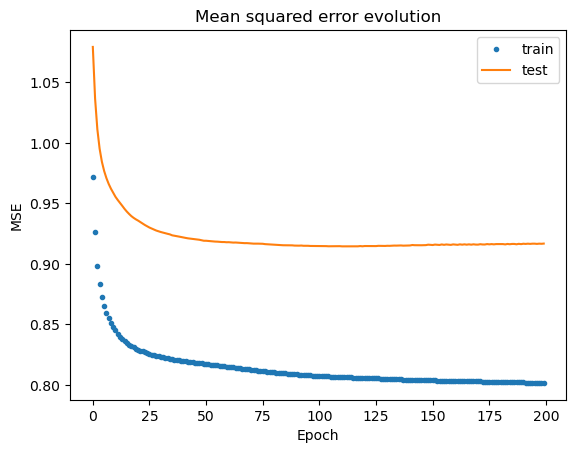

In [16]:
# Specification of learning parametrization.
estimator = TwoLayerNN(40)

# Parameters used in training loop
epsilon=0.01
batch_size = 64

# Specify the optimizer that is used to perform descent updates
optimizer = optim.SGD(estimator.parameters(), lr=epsilon, momentum=0)


# Instantiate Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

mse_evolution = []
mse_evolution_test = []


# Training loop
n_epochs = 200
# Iterate n_epochs times over the whole dataset.

for _ in range(n_epochs):
    #iterate over all batches in the dataset
    for x_batch, y_batch in train_loader:
        
        # set gradients to zero
        estimator.zero_grad() 
        
        # Compute predictions
        yHat = estimator.forward(x_batch).squeeze()
        # Compute error
        mse = torch.mean((yHat-y_batch)**2)

        # Compute gradients
        mse.backward()
        
        # Update parameters
        optimizer.step()

    epoch_mse = evaluate(train_loader, estimator)    
    mse_evolution.append(epoch_mse)
    
    mseTest = evaluate(test_loader, estimator)  
    mse_evolution_test.append(mseTest)

# Print train results
print(f"Train loss: {mse_evolution[-1]} ")

# Print test results
print(f"Test loss: {mse_evolution_test[-1]} ")
_ = plt.plot(mse_evolution, ".", label="train")
_ = plt.title("Mean squared error evolution")
_ = plt.xlabel("Epoch")
_ = plt.ylabel("MSE")
_ = plt.plot(mse_evolution_test, "-", label="test")
_ = plt.legend()
_ = plt.savefig("1Ctasfk2.pdf")
 

## Task 3

We will incorporate the gender data that we have so far ignored. To that end encode gender as $\text{Female} = 1$ and $\text{Male} = -1$. Redefine the object in Task 1 so that it can now process this information. In this neural network we use a single intermediate layer with $20$ hidden neurons.

In [17]:
from math import sqrt
class TwoLayerNN(torch.nn.Module):
    def __init__(self, p1=20):
        super().__init__()
        # we just modify the input dimension to 3
        self.A1 = nn.parameter.Parameter((torch.rand(3, p1)-0.5))
        self.A2 = nn.parameter.Parameter((torch.rand(p1, 1)-0.5))
    def forward(self, x0):
        # compute output of first layer
        x1 = relu(torch.matmul(x0, self.A1))
        # compute output of second layer
        x2 = relu(torch.matmul(x1,self.A2))
        return x2

## Task 4

Divide the data of Lab 1A into a test set with $\tilde{N} = 100$ samples and use the remaining samples as a training set. Use it to train the neural network of Task 1. \blue{Add step size suggestions.} Evaluate the training error and the test error. 

Given that we have decided to use gender information in our decisions, it is fair that we are asked what effect this choice has. Evaluate the average predicted GPA for Female and Male applicants and observe that data can be perilous. Or not. Comment.

In [18]:
# We use both the normalized HS GPA and the SAT scores
# The targets are the normalized Penn GPA values
gender =  data_norm[:,3] -  data_norm[:,4]
gender = (gender-torch.mean(gender))/torch.std(gender)
x = torch.hstack((data_norm[:,:2], gender.unsqueeze(1)))
y = data_norm[:,2]

# Data
train_dataset = TensorDataset(x[train_indices], y[train_indices])
test_dataset = TensorDataset(x[test_indices], y[test_indices])

Train loss: 0.7897461291032101 
Test loss: 0.8599131732834959 


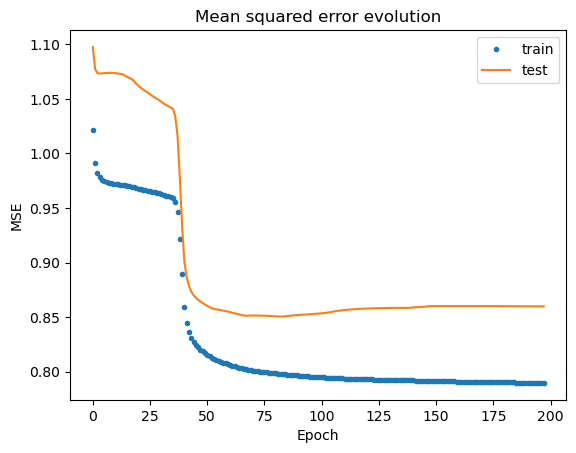

In [19]:
# Specification of learning parametrization.
estimator = TwoLayerNN(40)

# Parameters used in training loop
epsilon=0.01
batch_size = 64

# Specify the optimizer that is used to perform descent updates
optimizer = optim.SGD(estimator.parameters(), lr=epsilon, momentum=0)


# Instantiate Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

mse_evolution = []
mse_evolution_test = []


# Training loop
n_epochs = 200
# Iterate n_epochs times over the whole dataset.

for _ in range(n_epochs):
    #iterate over all batches in the dataset
    for x_batch, y_batch in train_loader:
        
        # set gradients to zero
        estimator.zero_grad() 
        
        # Compute predictions
        yHat = estimator.forward(x_batch).squeeze()
        # Compute error
        mse = torch.mean((yHat-y_batch)**2)
        # Compute gradients
        mse.backward()
        
        # Update parameters
        optimizer.step()
    epoch_mse = evaluate(train_loader, estimator)    
    mse_evolution.append(epoch_mse)
    
    mseTest = evaluate(test_loader, estimator)  
    mse_evolution_test.append(mseTest)

# Print train results
print(f"Train loss: {mse_evolution[-1]} ")

# Print test results
print(f"Test loss: {mse_evolution_test[-1]} ")
_ = plt.plot(mse_evolution[2:], ".", label="train")
_ = plt.title("Mean squared error evolution")
_ = plt.xlabel("Epoch")
_ = plt.ylabel("MSE")
_ = plt.plot(mse_evolution_test[2:], "-", label="test")
_ = plt.legend()
_ = plt.savefig("1Ctasfk4.pdf")
 

In [20]:
male_indexes = gender < 0
male_yHat = torch.mean(estimator.forward(x[male_indexes]).squeeze())

female_indexes = gender > 0
female_yHat = torch.mean(estimator.forward(x[female_indexes]).squeeze())

print(f"Average Male GPA: {stds[2] * male_yHat + means[2]} ")
print(f"Average Female GPA: {stds[2] * female_yHat + means[2]}")

Average Male GPA: 3.5958956072204615 
Average Female GPA: 3.6118699134595706
